# Machine Learning for Weather Forecasting<br>An Analysis of Univariate and Multivariate Models

Ted Dickey



## Introduction
- Brief overview of the project and its goals


Weather forecasting plays a crucial role in various industries, including agriculture, transportation, and disaster preparedness. Accurate and reliable predictions can provide valuable insights and aid decision-making processes. This project focuses on leveraging machine learning models, particularly LSTM neural networks, to forecast weather patterns over time.

The primary objective of this project is to develop and compare multiple machine learning models for weather forecasting. We will explore various models, including LSTM, CNN1D, XGBoost, and GRU, to capture temporal dependencies and patterns in the historical weather data. Additionally, we will analyze the performance of these models, considering both univariate and multivariate regression scenarios.

By training these models on extensive historical weather data, we aim to improve the accuracy and reliability of weather predictions. We will evaluate the models using metrics such as root mean squared error (RMSE), R-squared, and mean absolute error (MAE). Furthermore, we will investigate the interpretability of the models, analyze feature importance, and explore hyperparameter tuning to optimize their performance.

Through this project, we aspire to contribute to the field of weather forecasting and enable better decision-making in various industries that rely on accurate weather predictions.


## Data Preprocessing

- Data cleaning and preprocessing techniques applied to prepare the dataset for modeling


In [2]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('Solarize_Light2')    # This is a popular style choice for matplotlib

In [9]:
# Read the data
df = pd.read_csv('weather.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


We see that the weather data is in 10-minute intervals.  We will not need this level of granularity.  Instead we will tranform to hourly by taking every 6th record.

In [10]:
df = df[5::6] # Select one observation every six rows
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


 Create the datetime index for the Data frame and remove the Date Time column


In [11]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S').dt.strftime('%Y-%m-%d %H:%M:%S')
df.index = pd.to_datetime(df.index)

df.index[:26]

DatetimeIndex(['2009-01-01 01:00:00', '2009-01-01 02:00:00',
               '2009-01-01 03:00:00', '2009-01-01 04:00:00',
               '2009-01-01 05:00:00', '2009-01-01 06:00:00',
               '2009-01-01 07:00:00', '2009-01-01 08:00:00',
               '2009-01-01 09:00:00', '2009-01-01 10:00:00',
               '2009-01-01 11:00:00', '2009-01-01 12:00:00',
               '2009-01-01 13:00:00', '2009-01-01 14:00:00',
               '2009-01-01 15:00:00', '2009-01-01 16:00:00',
               '2009-01-01 17:00:00', '2009-01-01 18:00:00',
               '2009-01-01 19:00:00', '2009-01-01 20:00:00',
               '2009-01-01 21:00:00', '2009-01-01 22:00:00',
               '2009-01-01 23:00:00', '2009-01-02 00:00:00',
               '2009-01-02 01:00:00', '2009-01-02 02:00:00'],
              dtype='datetime64[ns]', name='Date Time', freq=None)

In [13]:
# Remove unneeded column
df.drop('Date Time', axis=1, inplace=True)
df.head()

KeyError: "['Date Time'] not found in axis"

In [14]:
print(df.index.dtype)

datetime64[ns]


- Summary Statistics

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70091 entries, 2009-01-01 01:00:00 to 2016-12-31 23:10:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         70091 non-null  float64
 1   T (degC)         70091 non-null  float64
 2   Tpot (K)         70091 non-null  float64
 3   Tdew (degC)      70091 non-null  float64
 4   rh (%)           70091 non-null  float64
 5   VPmax (mbar)     70091 non-null  float64
 6   VPact (mbar)     70091 non-null  float64
 7   VPdef (mbar)     70091 non-null  float64
 8   sh (g/kg)        70091 non-null  float64
 9   H2OC (mmol/mol)  70091 non-null  float64
 10  rho (g/m**3)     70091 non-null  float64
 11  wv (m/s)         70091 non-null  float64
 12  max. wv (m/s)    70091 non-null  float64
 13  wd (deg)         70091 non-null  float64
dtypes: float64(14)
memory usage: 8.0 MB


In [16]:
df.shape

(70091, 14)

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


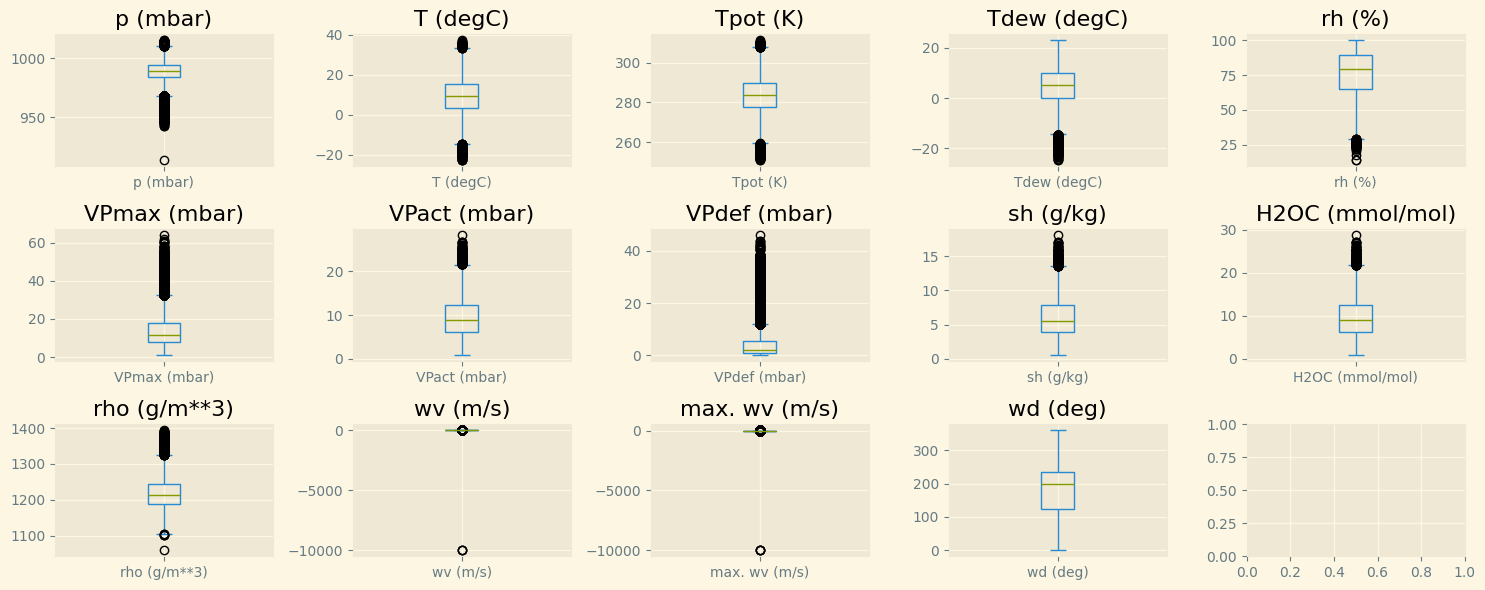

In [19]:
# Create a figure and axes for the boxplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 6))
axes = axes.flatten()

# Iterate over each column and plot the boxplot
for i, column in enumerate(df.columns):
    if column != 'Date Time': # We don't want to plot the datetime column
        df[column].plot.box(ax=axes[i])
        axes[i].set_title(column)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

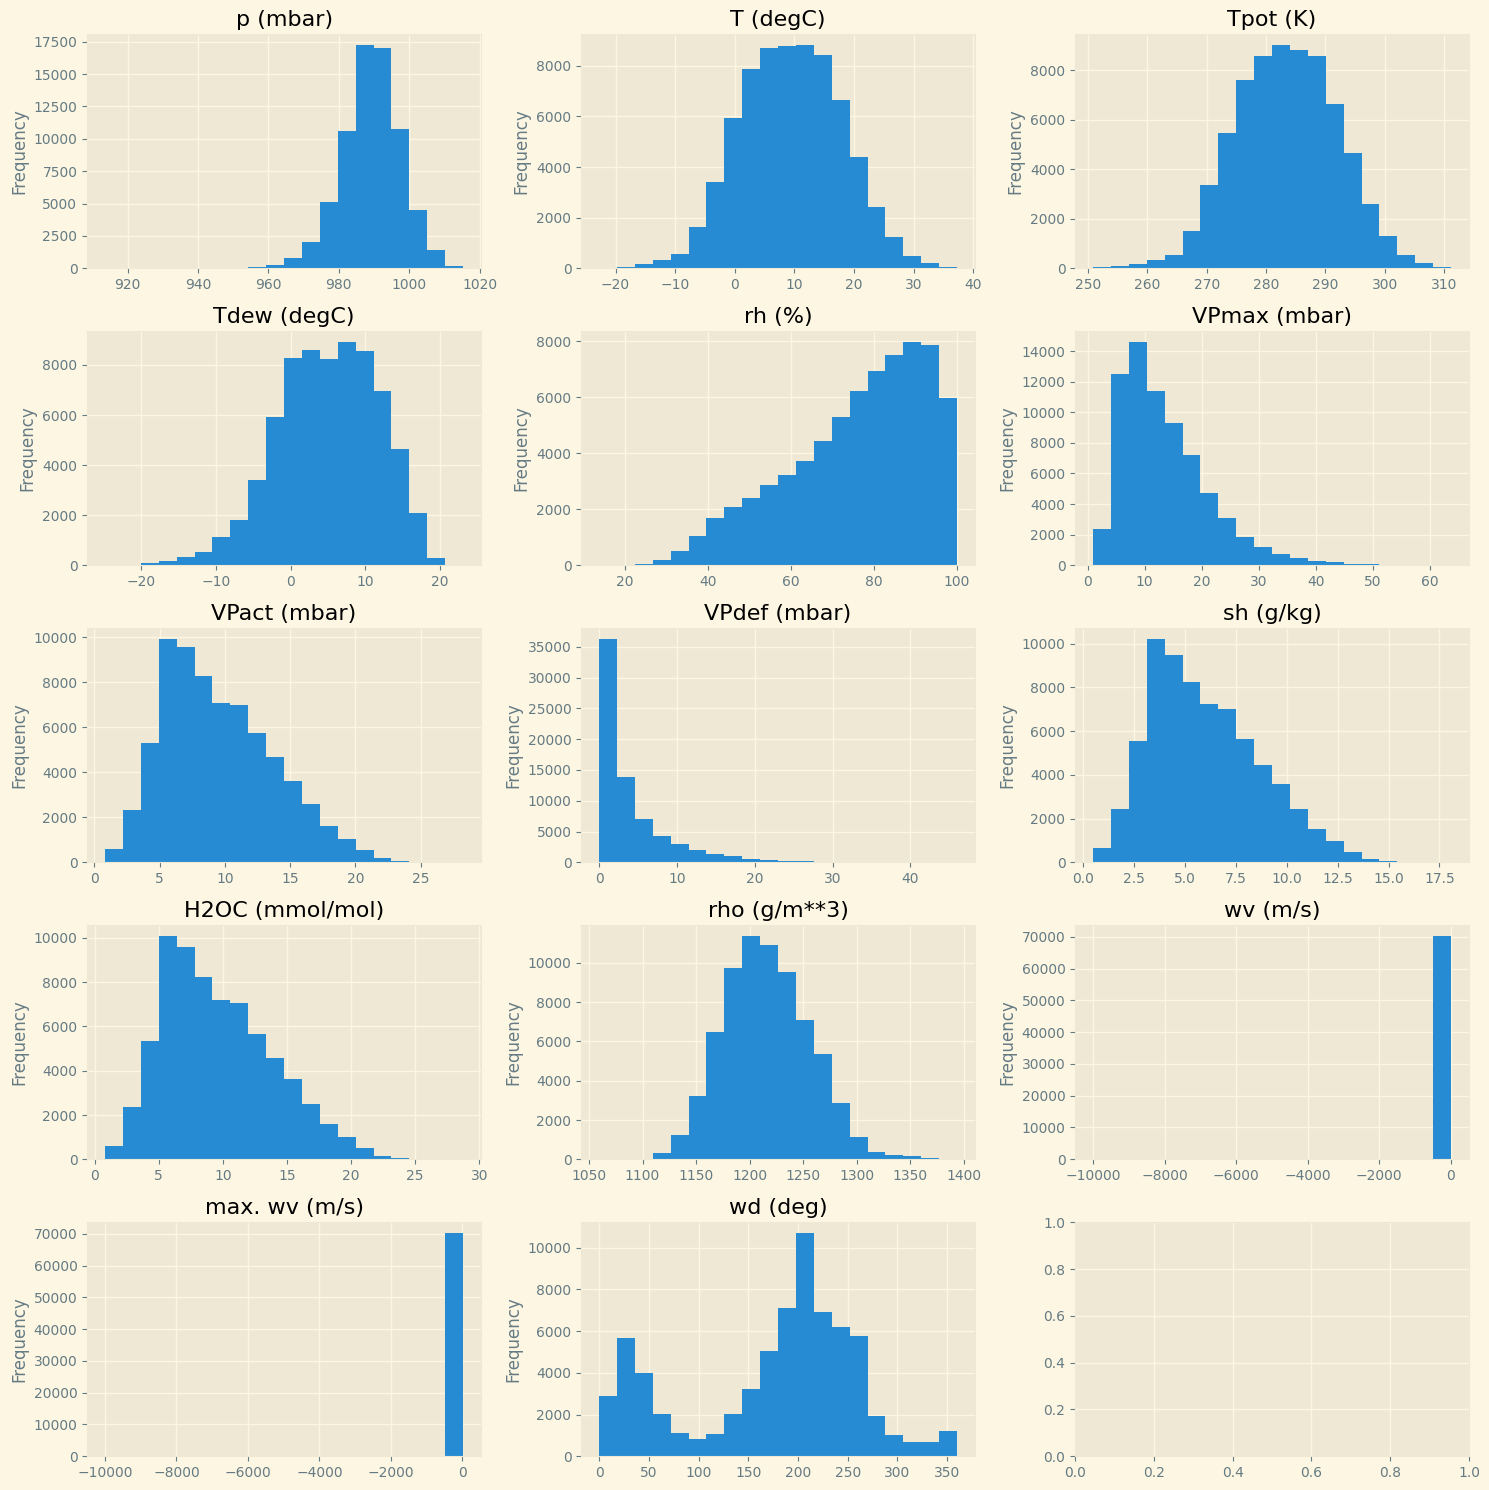

In [20]:
# Create a figure and axes for the histograms
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Iterate over each column and plot the histogram
for i, column in enumerate(df.columns):
    if column != 'Date Time': # We don't want to plot the datetime column

        df[column].plot.hist(ax=axes[i], bins=20)
        axes[i].set_title(column)
    else:
        print(f"Skipping column '{column}' as it contains non-numeric data.")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

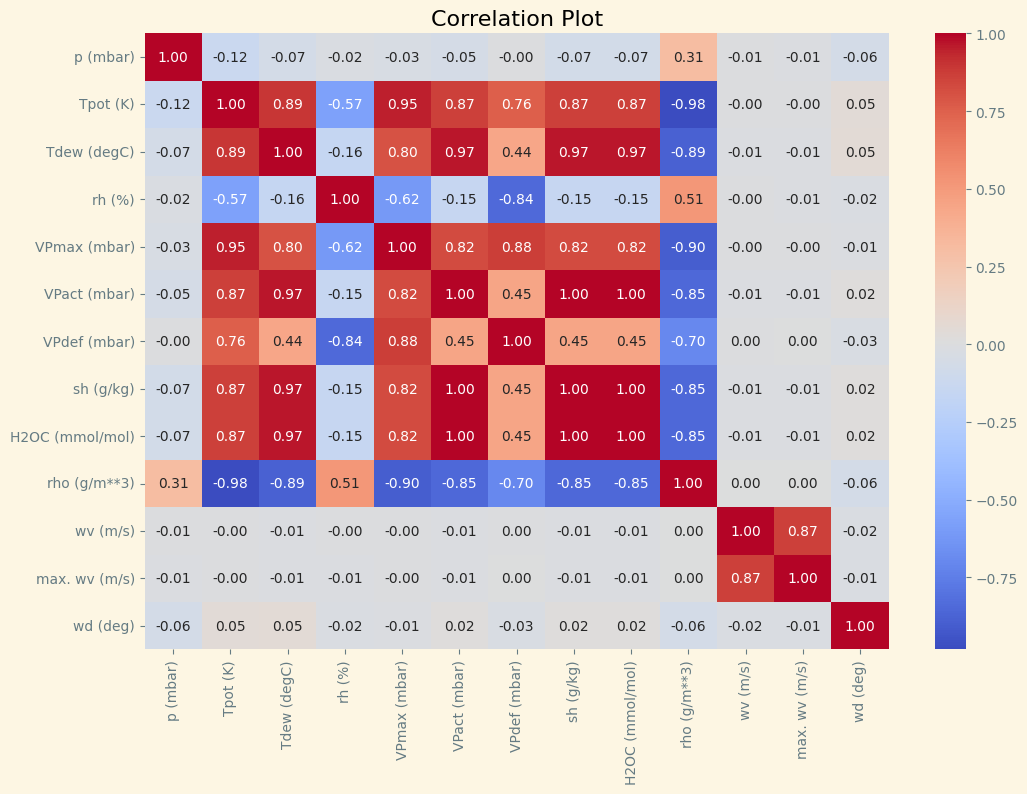

In [23]:

features = df.drop('T (degC)', axis=1)  # Exclude the dependent variable
correlation_matrix = features.corr()

# Create a correlation plot
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Plot')
plt.show()



- Handling missing values, outliers, and data normalization

In [24]:
# Later I will standardize Temperature, but for now I will leave it alone

## Model 1: LSTM Model - Single Variable
### Model Creation
- Description of the LSTM model architecture
- Feature selection and input representation

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE


## Model 2: CNN 1D Model - Single Variable
### Model Creation
- Description of the 1D CNN model architecture
- Input representation and convolutional layers

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE


## Model 3: GRU Model
### Model Creation
- Description of the GRU model architecture
- Input representation and recurrent layers

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE

## Model 4: Decision Tree Model
### Model Creation
- Description of the Decision tree model architecture
- Input representation and recurrent layers

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE

## Model 4: LSTM Model - Multivariate Regression
### Model Creation
- Description of the LSTM model architecture for multivariate regression
- Feature selection and input representation

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE

## Model 5: LSTM Model - 2 Neurons
### Model Creation
- Description of the LSTM model architecture with 2 neurons
- Feature selection and input representation

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE

## Model 6: LSTM Model - Larger Window - Single Variable
### Model Creation
- Description of the LSTM model architecture with a larger window size
- Feature selection and input representation

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE

## Model 7: CNN1D Model - Single Variable (More Layers)
### Model Creation
- Description of the 1D CNN model architecture with additional layers
- Input representation and convolutional layers

### Training and Validation
- Splitting the data into training and validation sets
- Training the model on the training set
- Evaluating model performance on the validation set
- Discussion of validation loss and convergence

### Testing and Predictions
- Testing the trained model on the test dataset
- Generating predictions using the trained model
- Plotting predictions vs. actual values
- Performance metrics: RMSE, R-squared, MAE

## Performance Comparison of Single Neuron Models
- Table comparing the performance of all single neuron models
- Evaluation metrics: RMSE, R-squared, MAE

## Feature Importance Analysis
- Analyzing the importance of different features in the models
- Techniques used: feature importance plots, permutation importance

## Hyperparameter Tuning
- Description of hyperparameter tuning techniques and optimization algorithms used
- Discussion of the impact of hyperparameter tuning on model performance

## Model Interpretability
- Techniques for interpreting the trained models
- SHAP values, partial dependence plots, LIME analysis, etc.

## Robustness Analysis
- Analysis of model robustness through sensitivity analysis or testing on different data subsets

## Limitations and Future Work
- Acknowledgment of study limitations and potential improvements
- Suggestions for future research directions and enhancements to the models

## Conclusion
- Summary of the project, key findings, and implications

## The End